# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [3]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [4]:
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

In [5]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_customer_churn').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
df = spark.read.json('mini_sparkify_event_data.json')
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [9]:
df.describe('sessionId').show()


+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [10]:
df.count()


286500

# Clean Data

Remove NAN or '' values from userId & sessionId columns
Also convert time column into format '%Y-%m-%d %H:%M:%S'


In [11]:
df.filter(isnull(df['userId'])).count()


0

In [12]:
df.filter(isnull(df['sessionId'])).count()


0

In [13]:
df.filter(df['userId']=='').count()


8346

In [14]:
df.filter(df['sessionId']=='').count()


0

In [15]:
df_cleaned = df.filter(df['userId']!='')


In [16]:
# Create a user defined function for formating the timestamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#Apply the udf on the ts column
df_cleaned = df_cleaned.withColumn("time", get_time(df_cleaned.ts))

In [17]:
df_cleaned.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 00:01:57')]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.



### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [18]:
#Create a temporary view to perform SQL operations
df_cleaned.createOrReplaceTempView("sparkify_cleaned")

## User Auth

In [19]:
spark.sql('''
        SELECT DISTINCT(auth)
        FROM sparkify_cleaned
''').show()


+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [20]:

spark.sql('''
        SELECT auth,COUNT(DISTINCT userId) AS user_counts
        FROM sparkify_cleaned
        GROUP BY auth
        ORDER BY user_counts DESC
''').show()

+---------+-----------+
|     auth|user_counts|
+---------+-----------+
|Logged In|        225|
|Cancelled|         52|
+---------+-----------+



#### 52 users cancelled the subscription .


## User Gender

In [21]:
gender_count = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_counts
        FROM sparkify_cleaned
        GROUP BY gender
        ORDER BY user_counts DESC
''')
gender_count.show()

+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



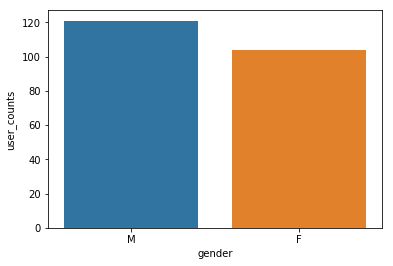

In [22]:
sns.barplot(x='gender',y='user_counts',data=gender_count.toPandas());


#### There are 124 males and 104 females

## Items played in a session

In [23]:
spark.sql('''
        SELECT COUNT(DISTINCT(itemInSession)) AS item_counts
        FROM sparkify_cleaned
''').show()

+-----------+
|item_counts|
+-----------+
|       1311|
+-----------+



In [24]:
length_data = spark.sql('''
        SELECT length
        FROM sparkify_cleaned
''')

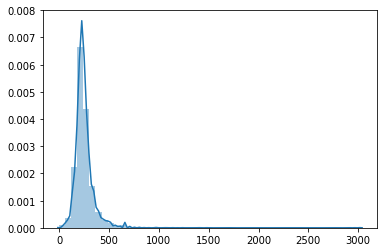

In [25]:
sns.distplot(length_data.toPandas().dropna());


#### Most of the songs length are from 0 to 500

## User Level

In [26]:
spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_counts
        FROM sparkify_cleaned
        GROUP BY level
        ORDER BY user_counts DESC
''').show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|        195|
| paid|        165|
+-----+-----------+



#### There  are 195 free users and 165 paid , which means 135 people upgraded their level

## User Location

In [27]:
location_count = spark.sql('''
        SELECT location,COUNT(DISTINCT userId) AS user_counts
        FROM sparkify_cleaned
        GROUP BY location
        ORDER BY user_counts DESC
''').toPandas()

In [28]:
location_count.head()

,location,user_counts
0,"Los Angeles-Long Beach-Anaheim, CA",16
1,"New York-Newark-Jersey City, NY-NJ-PA",15
2,"Phoenix-Mesa-Scottsdale, AZ",7
3,"Dallas-Fort Worth-Arlington, TX",7
4,"St. Louis, MO-IL",6


In [29]:
#split city and state
location_count = location_count.join(location_count['location'].str.split(',',expand=True).rename(columns={0:'city',1:'state'})).drop('location',axis=1)

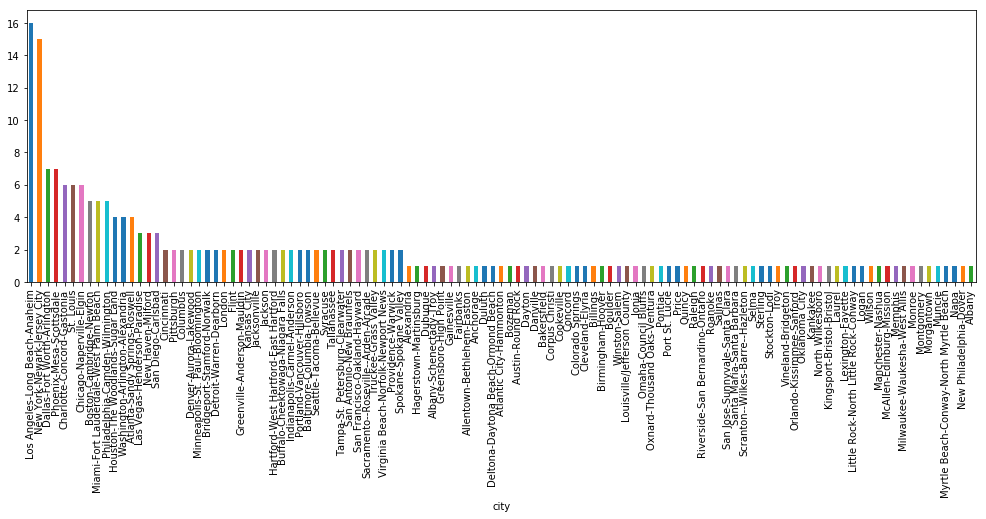

In [30]:
location_count.groupby('city')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));


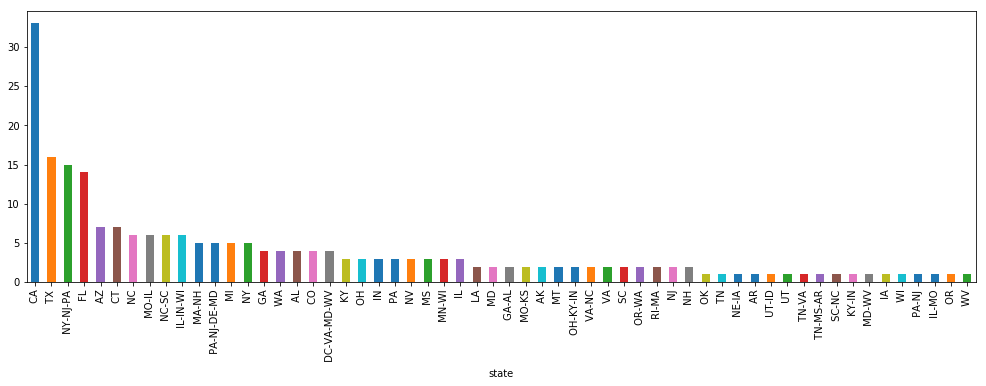

In [31]:
location_count.groupby('state')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));


### Los Angeles and New York are top cities which have the largest user count, and California is the top state has the largest user count.



## Page Wise User Count

In [32]:
spark.sql('''
        SELECT page,COUNT(userId) AS user_counts
        FROM sparkify_cleaned
        GROUP BY page
        ORDER BY user_counts DESC
''').show()

+--------------------+-----------+
|                page|user_counts|
+--------------------+-----------+
|            NextSong|     228108|
|           Thumbs Up|      12551|
|                Home|      10082|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|         Roll Advert|       3933|
|              Logout|       3226|
|         Thumbs Down|       2546|
|           Downgrade|       2055|
|            Settings|       1514|
|                Help|       1454|
|             Upgrade|        499|
|               About|        495|
|       Save Settings|        310|
|               Error|        252|
|      Submit Upgrade|        159|
|    Submit Downgrade|         63|
|              Cancel|         52|
|Cancellation Conf...|         52|
+--------------------+-----------+



### User Agent

In [33]:
userAgent_count = spark.sql('''
        SELECT userAgent,COUNT(DISTINCT userId) AS user_counts
        FROM sparkify_cleaned
        GROUP BY userAgent
        ORDER BY user_counts DESC
''').toPandas()

In [34]:
def get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN


In [35]:
userAgent_count['browser'] = userAgent_count['userAgent'].apply(get_browser)


In [36]:

platform_dict = {'compatible': 'Windows',  'iPad': 'iPad',  'iPhone': 'iPhone',  
          'Macintosh': 'Mac',  'Windows NT 5.1': 'Windows','Windows NT 6.0': 'Windows', 'Windows NT 6.1': 'Windows',  
          'Windows NT 6.2': 'Windows',  'Windows NT 6.3': 'Windows', 'X11': 'Linux'}

In [37]:
userAgent_count['platform'] = userAgent_count['userAgent'].str.extract(r'\(([^\)]*)\)')[0].str.split(';').str[0].map(platform_dict)


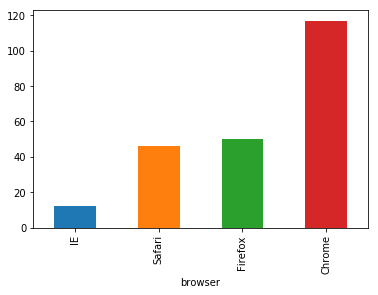

In [38]:
userAgent_count.groupby('browser')['user_counts'].sum().sort_values().plot(kind='bar');


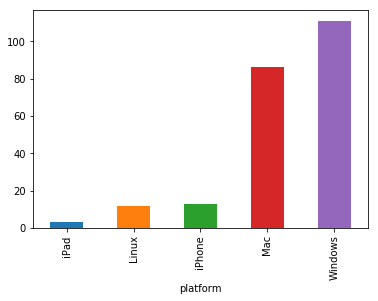

In [39]:
userAgent_count.groupby('platform')['user_counts'].sum().sort_values().plot(kind='bar');


### Time of day 

In [40]:
time_data = spark.sql('''
        SELECT time,userId
        FROM sparkify_cleaned
''').toPandas()

In [41]:
time_data['time'] = pd.to_datetime(time_data['time'])


In [42]:
weekday_dict = {0:'Mon.',1:'Tues.',2:'Wed.',3:'Thur.',4:'Fri.',5:'Sat.',6:'Sun.'}
time_data['weekday'] = time_data['time'].dt.weekday.map(weekday_dict)
time_data['day'] = time_data['time'].dt.day
time_data['hour'] = time_data['time'].dt.hour

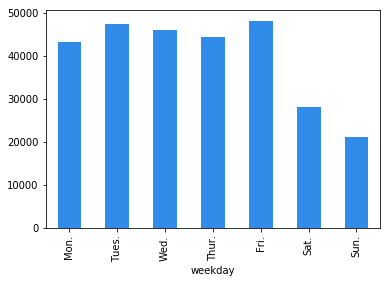

In [43]:
time_data.groupby('weekday')['userId'].count().loc[list(weekday_dict.values())].plot(kind='bar',color='#318ce7');


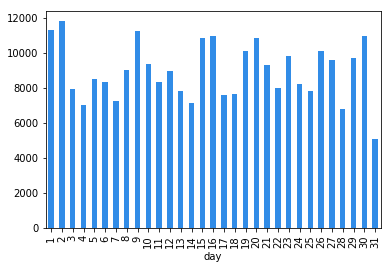

In [44]:
time_data.groupby('day')['userId'].count().plot(kind='bar',color='#318ce7');


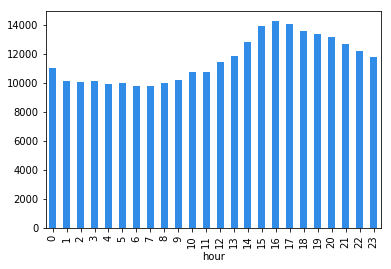

In [45]:
time_data.groupby('hour')['userId'].count().plot(kind='bar',color='#318ce7');


#### Users behaviors are periodic, they use Sparkify more often in weekdays than weekend; In one single day, they use Sparkify more often after 14 o'clock.



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [46]:
#first we should define a column named Churn as dataset's label for predict
#find the flag event
df_cleaned.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [47]:
#define the flag event udf to transform event to 0 or 1
flag_event = udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())

In [48]:
#define the current churn or not state
df_cleaned_cancel = df_cleaned.withColumn('Churn_state',flag_event('page'))

In [49]:
#mark the user who have churned event
userwindow = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df_cleaned_cancel = df_cleaned_cancel.withColumn('Churn',fmax('Churn_state').over(userwindow))

In [50]:
df_cleaned_cancel.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', time='2018-10-08 12:58:54', Churn_state=0, Churn=0)]

In [51]:
df_cleaned_cancel.dropDuplicates(['userId']).select('Churn').groupby('Churn').count().collect()


[Row(Churn=1, count=52), Row(Churn=0, count=173)]

#### So, there are 52 users have churned events in the dataset, it's about 23.1% churned rate. The rate of churn and not churn is roughly 1:3



In [52]:
def normalize_data(groupby_data):
    groupby_series = groupby_data.set_index(list(groupby_data.columns[:2]))
    temp = groupby_series.unstack('Churn').fillna(0)
    df = pd.DataFrame(((temp - temp.min()) / (temp.max() - temp.min())).stack()).reset_index()
    df = df.rename(columns={df.columns[-1]:'result'})
    return df

In [53]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [54]:
df_cleaned_cancel = df_cleaned_cancel.withColumn('hour', get_hour(df_cleaned_cancel.ts))
df_cleaned_cancel = df_cleaned_cancel.withColumn('day', get_day(df_cleaned_cancel.ts))
df_cleaned_cancel = df_cleaned_cancel.withColumn('dayofweek', get_weekday(df_cleaned_cancel.ts))

In [55]:
hour_data = df_cleaned_cancel.select(["Churn", "hour"]).groupby(["Churn", "hour"]).count().sort("hour").toPandas()
day_data = df_cleaned_cancel.select(["Churn", "day"]).groupby(["Churn", "day"]).count().sort("day").toPandas()
dayofweek_data = df_cleaned_cancel.select(["Churn", "dayofweek"]).groupby(["Churn", "dayofweek"]).count().sort("dayofweek").toPandas()

In [56]:
hour_data = normalize_data(hour_data)


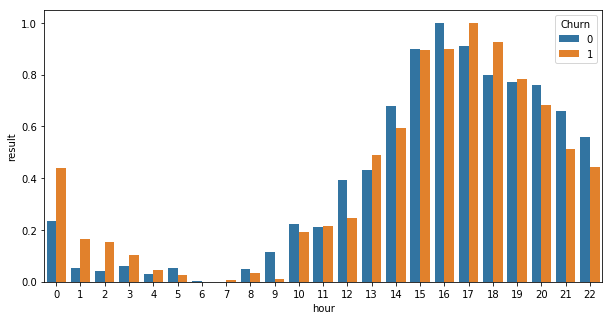

In [57]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="hour",y="result", hue="Churn", data=hour_data,ax=ax,order=list(map(lambda x: str(x),range(23))));

In [58]:
day_data = normalize_data(day_data)


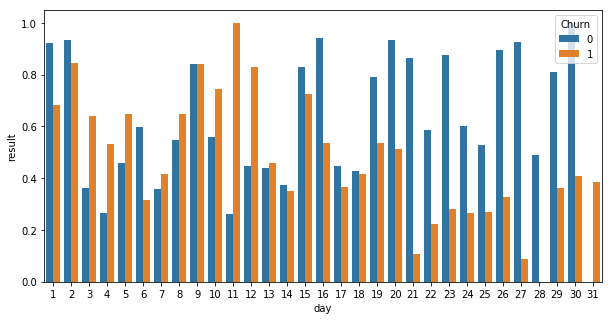

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="day",y="result", hue="Churn", data=day_data,ax=ax,order=list(map(lambda x: str(x),range(1,32))));

In [60]:
dayofweek_data = normalize_data(dayofweek_data)


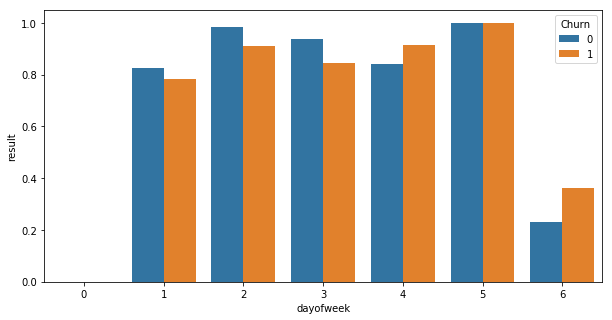

In [61]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="dayofweek",y="result", hue="Churn", data=dayofweek_data,ax=ax);

In [62]:
browser = udf(lambda x : get_browser(x))


In [63]:
#get browsers
df_cleaned_cancel = df_cleaned_cancel.withColumn('browser',browser(df_cleaned_cancel.userAgent))

In [64]:
get_platform = udf(lambda x: platform_dict[re.findall(r'\(([^\)]*)\)',x)[0].split(';')[0]])


In [65]:
#get platform
df_cleaned_cancel = df_cleaned_cancel.withColumn('platform',get_platform(df_cleaned_cancel.userAgent))

In [66]:
browser_data = df_cleaned_cancel.select(["browser","Churn"]).groupby([ "browser","Churn"]).count().sort("browser").toPandas()


In [67]:
browser_data = normalize_data(browser_data)


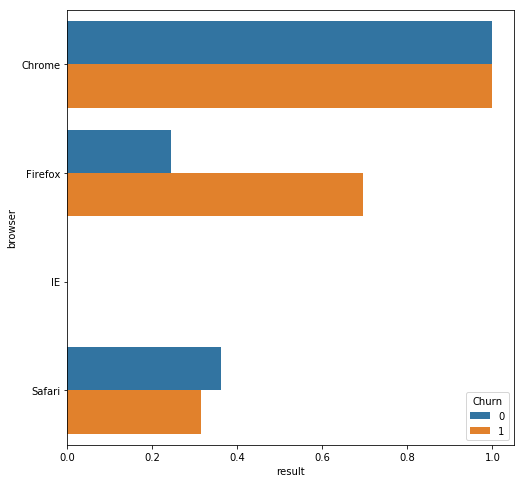

In [68]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="result",y="browser", hue="Churn", data=browser_data,ax=ax);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [69]:
df_cleaned_cancel.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- Churn_state: integer (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- dayofweek: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- platform: string (nullable = tru

#### On the basis of the above EDA, we can create features as follows:

##### Categorical Features 
* gender
* level
* browser
* platform
##### Numerical Features
* mean,max,min,std of length of users
* numbers of these item in page (NextSong,ThumbsUp, ThumbsDown, AddtoPlaylist, AddFriend, RollAdvert)
* number of unique songs and total songs of users
* number of unique artists of users
* percentage of operations after 15th in a month
* percentage of operations in workday

In [70]:
def label_encoding(col_name):
    '''
    transform categorical items to number
    '''
    temp = df_cleaned_cancel.select([col_name]).dropDuplicates().toPandas()
    label_dict = {val:str(idx) for idx,val in enumerate(temp[col_name].tolist())}
    result = df_cleaned_cancel.dropDuplicates(['userId']).select(['userId',col_name]).replace(label_dict,subset=col_name)
    return result

In [71]:
def get_categorical_features():
    '''
    join all categorical features together
    '''
    feature_gender = label_encoding('gender')
    feature_level = label_encoding('level')
    feature_browser = label_encoding('browser')
    feature_platform = label_encoding('platform')
    
    result = feature_gender.join(feature_level,on='userId',how='inner').\
                            join(feature_browser,on='userId',how='inner').\
                            join(feature_platform,on='userId',how='inner')
    return result

In [72]:
categorical_feature = get_categorical_features()


In [73]:
categorical_feature.show(2)

+------+------+-----+-------+--------+
|userId|gender|level|browser|platform|
+------+------+-----+-------+--------+
|100010|     0|    0|      1|       1|
|200002|     1|    0|      1|       1|
+------+------+-----+-------+--------+
only showing top 2 rows



In [74]:
def get_numerical_features():
    '''
    join all numerical features together and implement Standscaler
    '''
    #length
    feature_length = df_cleaned_cancel.select(["userId", "length"]).groupby(["userId"]).agg(avg('length').alias('mean_length'), 
                                                                     stddev('length').alias('stdev_length'),
                                                                    fmax('length').alias('max_length'),
                                                                    fmin('length').alias('min_length'))
    
    #page, reference url:https://stackoverflow.com/questions/56051438/pivot-table-in-pyspark
    page_count = df_cleaned_cancel.select(["userId","page"]).groupby(["userId","page"]).count()
    # create the pivot table
    temp1 = page_count.groupby('userId').pivot('page').agg(first('count')).fillna(0)
    # filter columns
    temp1 = temp1.select(['userId','NextSong','Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Roll Advert'])
    # column names used to sum up for total
    cols = temp1.columns[1:]
    # calculate the total 
    feature_page = temp1.withColumn('total', sum([col(c) for c in cols]))    
    
    
    #unique songs number
    feature_nunique_song = df_cleaned_cancel.filter(df_cleaned_cancel.page=='NextSong').select(["userId","song"]).\
                                             dropDuplicates(["userId","song"]).groupby(["userId"]).count()
    feature_nunique_song = feature_nunique_song.selectExpr("userId as userId","count as nunique_song")
    
    #total songs number
    feature_ntotal_song = df_cleaned_cancel.filter(df_cleaned_cancel.page=='NextSong').select(["userId","song"]).\
                                             groupby(["userId"]).count()
    #source:https://exceptionshub.com/how-to-change-dataframe-column-names-in-pyspark.html
    feature_ntotal_song = feature_ntotal_song.selectExpr("userId as userId","count as ntotal_song")
    
    #unique artists artist
    feature_nunique_artist = df_cleaned_cancel.filter(df_cleaned_cancel.page=='NextSong').select(["userId","artist"]).\
                                               dropDuplicates(["userId","artist"]).groupby(["userId"]).count()
    feature_nunique_artist = feature_nunique_artist.selectExpr("userId as userId","count as nunique_artist")
    
    #percentage of opretions
    day_count = df_cleaned_cancel.filter(df_cleaned_cancel.day>=15).select(['userId']).groupby(["userId"]).count()
    day_count = day_count.selectExpr("userId as userId","count as day_count")
    
    total_count = df_cleaned_cancel.select(['userId']).groupby(["userId"]).count()
    total_count = total_count.selectExpr("userId as userId","count as total_count")
    
    dayofweek_count = df_cleaned_cancel.filter(df_cleaned_cancel.dayofweek<5).select(['userId']).groupby(["userId"]).count()
    dayofweek_count = dayofweek_count.selectExpr("userId as userId","count as dayofweek_count")
    
    feature_percentage_month = (total_count.alias("total").join(day_count.alias("day"), ["userId"]).\
                              select(col("userId"), (col("day.day_count") / col("total.total_count")).alias("month_percentage")))
    
    feature_percentage_week = (total_count.alias("total").join(dayofweek_count.alias("day"), ["userId"]).\
                          select(col("userId"), (col("day.dayofweek_count") / col("total.total_count")).alias("week_percentage")))
    
    #merge together
    result = feature_length.join(feature_page,on='userId',how='inner').\
                        join(feature_nunique_song,on='userId',how='inner').\
                        join(feature_ntotal_song,on='userId',how='inner').\
                        join(feature_nunique_artist,on='userId',how='inner').\
                        join(feature_percentage_month,on='userId',how='inner').\
                        join(feature_percentage_week,on='userId',how='inner')
    
    return result

In [75]:
label = df_cleaned_cancel.select(['userId','Churn']).dropDuplicates()


In [76]:
def get_data_for_train():
    '''
    merge features and label together
    '''
    categorical_feature = get_categorical_features()
    numerical_feature = get_numerical_features()
    label = df_cleaned_cancel.select(['userId','Churn']).dropDuplicates()
    result = categorical_feature.join(numerical_feature,on='userId',how='inner').join(label,on='userId',how='inner')
    
    #correct datatype
    for col_name in result.columns[1:5]:
        result = result.withColumn(col_name, result[col_name].cast(IntegerType()))
    for col_name in result.columns[5:-1]:
        result = result.withColumn(col_name, result[col_name].cast(FloatType()))
    
    #fill NaN
    result = result.na.fill(0)
    
  
    return result

In [77]:
final_data = get_data_for_train()


In [79]:
#backup final_data 
final_data.write.save('final_data_new3.json',format='json',header=True)

In [80]:
final_data = spark.read.json('final_data_new2.json')

In [81]:
final_data_columns = final_data.columns
final_data_columns.remove('Churn')
final_data_columns.remove('userId')

In [82]:
categorical_features = ['gender','level','browser','platform']
numerical_features = [col_name for col_name in final_data_columns if col_name not in categorical_features]

In [83]:
check_df = final_data.toPandas()

In [84]:
check_df.shape

(204, 22)

In [85]:
#implement standscaler
vector = VectorAssembler(inputCols=numerical_features, outputCol='numerical_features')
temp = vector.transform(final_data)
scaler = StandardScaler(withMean=True, withStd=True, inputCol='numerical_features', outputCol='features_scaled')
scaler_fit = scaler.fit(temp)
result_scaled = scaler_fit.transform(temp)

#add categorical features to feature vector

vector = VectorAssembler(inputCols=categorical_features+['features_scaled'], outputCol='all_features')
result_scaled = vector.transform(result_scaled)
final_result = result_scaled.select(result_scaled.Churn.alias('label'), result_scaled.all_features.alias('features'))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [86]:
def undersample(df): 
    '''
    Implement undersample on dataset, return a balanced dataset.
    '''    
    # size of minority class(0)
    minoritySize = df.where(df.label == '1').count()
    
    # two classes with the same size
    df_minority = df.where(df.label == '1')
    df_majority = df.where(df.label == '0').sample(1.0, seed=7).limit(minoritySize)
    
    # concatenate them together
    result = df_minority.union(df_majority)
    
    #shuffle data
    result = result.orderBy(rand())
    return result


In [87]:
balanced_data = undersample(final_result)


In [88]:
check_balanced_df = balanced_data.toPandas()

In [89]:
balanced_data.groupby(balanced_data.label).count().show()


+-----+-----+
|label|count|
+-----+-----+
|    0|   38|
|    1|   38|
+-----+-----+



In [90]:
train, test = balanced_data.randomSplit([0.7, 0.3], seed=7)


In [91]:
# Initialize four models
clf_LR = LogisticRegression(maxIter=50)
clf_DT = DecisionTreeClassifier(seed=7)
clf_RF = RandomForestClassifier(seed=7)
clf_SVM = LinearSVC()

In [92]:
evaluator= MulticlassClassificationEvaluator(predictionCol="prediction")

In [93]:

# collect results on the learners
all_results = {}
for clf in [clf_LR, clf_DT, clf_RF, clf_SVM]:
    model_results = {}
    # get the classifier name
    clf_name = clf.__class__.__name__
    
    
    # fit the dataset
    print(f'{clf_name} is training...')
    start = time.time() 
    model = clf.fit(train)
    end = time.time() 
    model_results['train_time'] = round(end-start,6)
    
    # predict
    print(f'{clf_name} is predicting...')
    start = time.time() 
    pred_test = model.transform(test)
    end = time.time()
    model_results['pred_time'] = round(end-start,6)
    
    #metrics
    print(f'{clf_name} is evaluating...')    
    model_results['f1_test'] = evaluator.evaluate(pred_test.select('label','prediction'),{evaluator.metricName: 'f1'})
    print('Test F1-score: ',model_results['f1_test'])
    all_results[clf_name] = model_results
    
all_results_df = pd.DataFrame(all_results)
all_results_df.to_csv('baseline.csv')

LogisticRegression is training...
LogisticRegression is predicting...
LogisticRegression is evaluating...
Test F1-score:  0.6085858585858586
DecisionTreeClassifier is training...
DecisionTreeClassifier is predicting...
DecisionTreeClassifier is evaluating...
Test F1-score:  0.5198467432950191
RandomForestClassifier is training...
RandomForestClassifier is predicting...
RandomForestClassifier is evaluating...
Test F1-score:  0.46851851851851856
LinearSVC is training...
LinearSVC is predicting...
LinearSVC is evaluating...
Test F1-score:  0.702075702075702


In [94]:
all_results_df


,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,LinearSVC
f1_test,0.608586,0.519847,0.468519,0.702076
pred_time,0.116291,0.134142,0.134124,0.121613
train_time,9.993120,4.092183,3.508062,51.391608


Though the LinearSVC spent more training time, but it can get the highest f1 score 0.702. And the LogisticRegression has a medium trainning time and f1 score, so will try to tune the LogisticRegression model 


In [95]:
paramGrid = ParamGridBuilder().\
            addGrid(clf_SVM.maxIter, [10, 100, 1000]).\
            addGrid(clf_SVM.regParam, [0.01,0.1,10.0,100.0]).\
            build()
crossval = CrossValidator(estimator=clf_SVM,
                      estimatorParamMaps=paramGrid,
                      evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                      numFolds=3)

In [96]:
start = time.time()
cvModel_SVM = crossval.fit(train)
end = time.time()
print(f'Model tuning is done, spent {end-start}s.')

Model tuning is done, spent 1096.886549949646s.


In [97]:
cvModel_SVM.avgMetrics


[0.503775962599492,
 0.4822725150666327,
 0.13759833435289825,
 0.13759833435289825,
 0.5593338760005427,
 0.4871794871794871,
 0.13759833435289825,
 0.13759833435289825,
 0.5593338760005427,
 0.4871794871794871,
 0.13759833435289825,
 0.13759833435289825]

In [98]:
pred = cvModel_SVM.transform(test)

print('Accuracy: {}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "f1"})))

Accuracy: 0.7407407407407407
F-1 Score:0.7371647509578544


In [99]:
cvModel_SVM.save('svm_model')


In [100]:
paramGrid = ParamGridBuilder().\
            addGrid(clf_LR.elasticNetParam,[0.1, 0.5, 1]).\
            addGrid(clf_LR.regParam,[0.01, 0.05, 0.1]).\
            build()

crossval = CrossValidator(estimator=clf_LR,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

In [101]:
start = time.time()
cvModel_LR = crossval.fit(train)
end = time.time()
print(f'Model tuning is done, spent {end-start}s.')

Model tuning is done, spent 196.16279363632202s.


In [102]:
cvModel_LR.avgMetrics


[0.5138888888888888,
 0.4623778998778998,
 0.4958876000542667,
 0.5216931216931217,
 0.44659523180765015,
 0.3587962962962963,
 0.5291296005581719,
 0.42723856209150324,
 0.2336914517557942]

In [103]:
pred = cvModel_LR.transform(test)

print('Accuracy: {}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "f1"})))

Accuracy: 0.7037037037037037
F-1 Score:0.702075702075702


In [104]:
cvModel_LR.save('lr_model')


In [105]:
(1097-197)/1097

0.8204193254329991

## Conclusion
As we can see in above, the logistic regression can get a nearly f1 score and save 82% time spending than the linear svc. So, the logistic regression is the best model from now on in this project.



# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.